# Objective:

**To classify food reviews into positive or negative using K Nearest Neghbors algorithm.**

This is a continuation of my ongoing study of the Amazon Food Reviews data available on Kaggle. Let's see how KNN performs on this dataset.

We'll try both **brute** and **kd_tree** algorithm for each of the vector representations of text reviews, i.e. for

* Bag of Words
* Tfidf
* Avg. W2V
* Tfidf weighted W2V

We'll select the best parameters by performing Grid Search on a bunch of values of **n_neighbors** and **weight** hyperparameters.

In [0]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sbn
from google.colab import drive
import os
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

Connect to google drive to load the cleaned dataframe.

In [0]:
drive.mount('/gdrive')

I had stored a dataframe with cleaned text reviews from the last excercise on my Google Drive. So there's no need to perform data cleaning again. The column 'cleaned_text' is free from stopwords, punctuation marks, HTML tags, and duplicate entries.

I simply need to load it. Let's do that by connecting this Google Colab environment with my Google Drive.

In [0]:
os.listdir('/gdrive/My Drive/amazon')

In [0]:
#con = sqlite3.connect(r'C:\Users\ucanr\Downloads\reviews_cleaned_final.sqlite')
con = sqlite3.connect('/gdrive/My Drive/amazon/reviews_cleaned_final.sqlite')
#con = sqlite3.connect('/home/ucanreachtvk/data/reviews_cleaned_final.sqlite')
df_full_clean = pd.read_sql('select * from Reviews;', con)
df_full_clean.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanut peanut...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citru g...


### Sorting by Timestamp

The reviews are likely to have a temporal structure. If we train our model on randomly sampled data, this structural information will be lost. Therefore, sort the dataframe by timestamp and select a subset from it from a contiguous timespan.

I'll use TimeSeriesSplit() to split the data for cross validation.

In [0]:
df_full_clean.sort_values(by=['Time'], ascending=True, inplace=True)
df_full_clean.head(4)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
117924,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
117901,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
298792,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
169281,212472,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...


The data is now sorted by time. Since this is a huge database, I'll have to sample only a small fraction of it, due to hardware limitations. 

In [0]:
df_full_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364171 entries, 117924 to 107253
Data columns (total 12 columns):
index                     364171 non-null int64
Id                        364171 non-null int64
ProductId                 364171 non-null object
UserId                    364171 non-null object
ProfileName               364171 non-null object
HelpfulnessNumerator      364171 non-null int64
HelpfulnessDenominator    364171 non-null int64
Score                     364171 non-null object
Time                      364171 non-null int64
Summary                   364171 non-null object
Text                      364171 non-null object
cleaned_text              364171 non-null object
dtypes: int64(5), object(7)
memory usage: 36.1+ MB


There are 364k reviews in the dataframe. Let's select the first 40,000 reviews.

In [0]:
df = df_full_clean.head(40000)[['Time', 'cleaned_text', 'Score']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 117924 to 211194
Data columns (total 3 columns):
Time            40000 non-null int64
cleaned_text    40000 non-null object
Score           40000 non-null object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [0]:
df.head()

,Time,cleaned_text,Score
117924,939340800,b'witti littl book make son laugh loud recit c...,positive
117901,940809600,b'rememb see show air televis year ago child s...,positive
298792,944092800,b'beetlejuic well written movi everyth excel a...,positive
169281,944438400,b'twist rumplestiskin captur film star michael...,positive
298791,946857600,b'beetlejuic excel funni movi keaton hilari wa...,positive


Let's see how the +/- reviews are distributed. The positive reviews are expected to be more than the negative ones.

In [0]:
df['Score'].value_counts()

positive    35593
negative     4407
Name: Score, dtype: int64

Let's map the score column in the dataframe

* positive : 1
* negative : 0


In [0]:
df['Score'] = df['Score'].map({'positive':1,'negative':0})

In [0]:
y = np.array(df['Score'])

Split the data into Train & Test.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'].values, y, test_size = 0.2, shuffle=False)

Train and Test data set sizes

In [0]:
print('Shape of X_train is {}.'.format(X_train.shape))
print('Shape of X_test is {}.'.format(X_test.shape))
print('Shape of y_train is {}.'.format(y_train.shape))
print('Shape of y_test is {}.'.format(y_test.shape))

Shape of X_train is (32000,).
Shape of X_test is (8000,).
Shape of y_train is (32000,).
Shape of y_test is (8000,).


## BoW

In this section, we'll convert the reviews into vectors using Bag of Words. Let's begin by defining the BOW object and fitting it to the training data.

First, let's see the contents of our training data set.



In [0]:
X_train[1]

b'rememb see show air televis year ago child sister later bought day thirti someth use seri book song student teach preschool turn whole school purchas along book children tradit live'

As can be seen above, our training set **X_train** contais 32,000 such reviews each one occupying a row in the numpy array. Note that this raw text cannot be processed by ML algorithms.

In [0]:
print('The shape of X_train is {}'.format(X_train.shape))
print('The shape X_test is {}'.format(X_test.shape))

The shape of X_train is (32000,)
The shape X_test is (8000,)


In [0]:
bow = CountVectorizer(ngram_range=(1,1))
bow_fit = bow.fit(X_train)

We can see the parameters of the fit model below.

In [0]:
bow_fit

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

This code block is just to help with clearing the memory during repeated executions.

In [0]:
try:
    
    del(X_train_transformed)
    del(my_cv)
    del(clf)
    del(tscv)

except NameError:
    
    print('One or more variables not found')

One or more variables not found


Convert training data corpus into BoW vector representation.

In [0]:
X_train_transformed = bow_fit.transform(X_train)

X_train_transformed is a sparse matrix that contains the BoW representation of the training data.

In [0]:
X_train_transformed

<32000x22440 sparse matrix of type '<class 'numpy.int64'>'
	with 939149 stored elements in Compressed Sparse Row format>

Convert test data also in the BoW format.

In [0]:
X_test_transformed = bow_fit.transform(X_test)
X_test_transformed.shape

(8000, 22440)

Standardize the data.

In [0]:
scaler = StandardScaler(with_mean=False)
X_train_transformed = scaler.fit_transform(X_train_transformed)

/home/ucanreachtvk/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ucanreachtvk/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Standardize test data

In [0]:
X_test_transformed = scaler.transform(X_test_transformed)

/home/ucanreachtvk/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### KNN with BoW | KD_tree

First, let's try KNN with KD_tree algorithm. KD_tree is computationally very expensive if #dimensions is very large.
So, we'll reduce the number of features in the Bag of Words array by using **SVD**.

In [0]:
svd = TruncatedSVD(n_components=100, random_state = 7)
X_train_transformed_svd = svd.fit_transform(X_train_transformed)
X_train_transformed_svd.shape

(32000, 100)

Note that the X_train_transformed array is not altered. It still contains the BoW vector with all features intact.

In [0]:
X_train_transformed

<32000x22440 sparse matrix of type '<class 'numpy.float64'>'
	with 939149 stored elements in Compressed Sparse Row format>

Also transform test data 

In [0]:
X_test_transformed_svd = svd.transform(X_test_transformed)
X_test_transformed_svd.shape

(8000, 100)

Sanity check if the transformed data has any NaN values

In [0]:
X_train_transformed_svd[~np.isnan(X_train_transformed_svd).any(axis=1)].shape

(32000, 100)

In [0]:
X_test_transformed_svd[~np.isnan(X_test_transformed_svd).any(axis=1)].shape

(8000, 100)

In [0]:
try:
    del(knn)
    del(clf)
    del(tscv)
    del(my_cv)
except:
    print('One or more variables not found')

One or more variables not found


To preserve the temporal structure of data, we'll split the data using TimeSeriesSplit() for cross validation.

In [0]:
tscv = TimeSeriesSplit(n_splits=3)
my_cv = tscv.split(X_train_transformed_svd)

To understand how this splits the data incrementally, consider the following example. train and test give the index of the split.

In [0]:
for train, test in tscv.split(X_train_transformed_svd[:6]):

    print(train, test)

[0 1 2] [3]
[0 1 2 3] [4]
[0 1 2 3 4] [5]


**Grid Search**

The KNN algorithm has two important parameters - the number of neighbors and weights (equal weight or priority based on distance). I'll search for the best set of these two parameters across the training data with time series cross validation splits. First for kd_tree algorithm then for brute.

Build GridSearchCV object for kd_tree algorithm of KNN.

In [0]:
knn = KNeighborsClassifier(algorithm = 'kd_tree')

param_grid = {
                'n_neighbors':[9,11,13,15],
                'weights' : ['uniform', 'distance']
             }

clf = GridSearchCV(estimator=knn, cv=my_cv, param_grid=param_grid, n_jobs=4, return_train_score=True)

In [0]:
%%notify
%%time

clf.fit(X_train_transformed_svd, y_train)

CPU times: user 2.23 s, sys: 327 ms, total: 2.55 s
Wall time: 17min 47s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f6c519ad1a8>,
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'n_neighbors': [9, 11, 13, 15], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

<IPython.core.display.Javascript object>

We can see the best parameters found like this -

In [0]:
clf.best_params_

{'n_neighbors': 15, 'weights': 'uniform'}

**Confusion Matrix**

Let's plot the confusion Matrix using the values predicted by the best estimator found by GridSearch for kd_tree algorithm of KNN for Bag Of Words format of data.

**Note**
* x-axis : predicted class
* y-axis : actual class

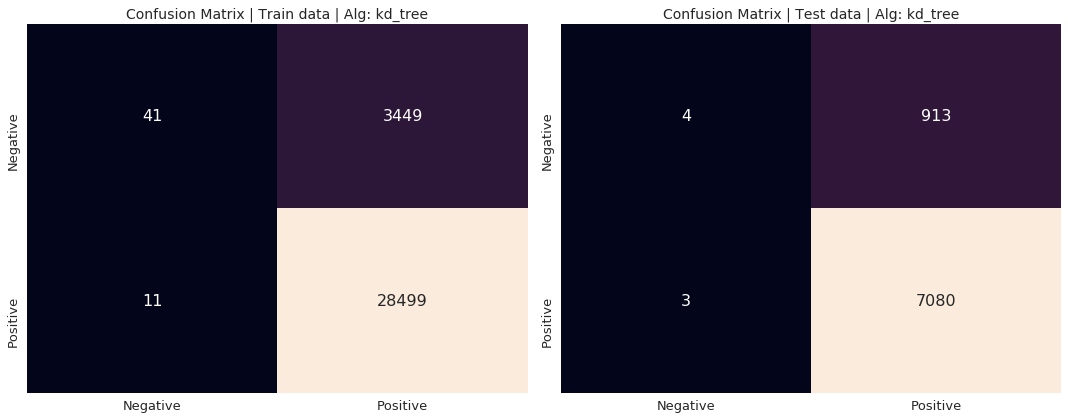

<IPython.core.display.Javascript object>

In [0]:
%%notify

sbn.set()

plt.figure(figsize=(15,6))#.suptitle('Confusion Matrix for Train and Test data')
plt.subplot(1,2,1)

cm_bow_kd_train = confusion_matrix(y_train, clf.predict(X_train_transformed_svd))
df_cm = pd.DataFrame(cm_bow_kd_train, range(2), range(2))
sbn.heatmap(df_cm, annot=True, annot_kws={"size":16}, cbar=False, fmt = 'd', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Confusion Matrix | Train data | Alg: kd_tree', fontsize = 14)

plt.subplot(1,2,2)
cm_bow_kd_test = confusion_matrix(y_test, clf.predict(X_test_transformed_svd))
df_cm = pd.DataFrame(cm_bow_kd_test, range(2), range(2))
sbn.heatmap(df_cm, annot=True, annot_kws={"size":16}, cbar=False, fmt = 'd', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Confusion Matrix | Test data | Alg: kd_tree', fontsize = 14)

plt.tight_layout()

**precision and recall**

In [0]:
# print('Recall for BoW | Kd_tree | train: {}'.format(recall_score(y_train, clf.predict(X_train_transformed_svd))))
# print('Recall for BoW | Kd_tree | test: {}'.format(recall_score(y_test, clf.predict(X_test_transformed_svd))))
# print('Precision for BoW | Kd_tree | train: {}'.format(precision_score(y_train, clf.predict(X_train_transformed_svd))))
# print('Precision for BoW | Kd_tree | test: {}'.format(precision_score(y_test, clf.predict(X_test_transformed_svd))))

tn, fp, fn, tp = cm_bow_kd_train.ravel()
print('Recall for BoW | Kd_tree | train: {}'.format(tp/(tp+fn)))
print('Precision for BoW | Kd_tree | train: {}'.format(tp/(tp+fp)))
tn, fp, fn, tp = cm_bow_kd_test.ravel()
print('Recall for BoW | Kd_tree | test: {}'.format(tp/(tp+fn)))
print('Precision for BoW | Kd_tree | test: {}'.format(tp/(tp+fp)))

Recall for BoW | Kd_tree | train: 0.999614170466503
Precision for BoW | Kd_tree | train: 0.8920433203956429
Recall for BoW | Kd_tree | test: 0.9995764506565015
Precision for BoW | Kd_tree | test: 0.885775053171525


**A useful function** 

Let me define a function that creates a dataframe with columns k, weight and prediction accuracy for various estimators tried in GridSearch. It will help me create a heatmap of accuracy for various values of k and weight.

This function will be used extensively in this notebook.  

In [0]:
def k_weight_score(cv_results_):

    D={'k':[], 'weight':[], 'score':[]}

    for k in [9,11,13,15]:

        for weight in ['uniform', 'distance']:

            d={'n_neighbors': k, 'weights': weight}

            ind=cv_results_['params'].index(d)
            D['k'].append(k)
            D['weight'].append(weight)
            D['score'].append(cv_results_['mean_train_score'][ind])
    
    return(pd.DataFrame.from_dict(D))

Call the above function for gridsearch we performed on BoW data for KD_tree algorithm. We'll save the dataframe returned for later use.

In [0]:
DF_bow_kd_train = k_weight_score(clf.cv_results_)

# import pickle
# fname = open('/home/ucanreachtvk/data/knn_pickle_files/DF_bow_kd_train_50k.pkl','wb')
# pickle.dump(DF_bow_kd_train,fname)
# fname.close()

### KNN with BoW | Brute 

Remember that the original numpy arrays *X_train_transformed & X_test_transformed* still contain the full BoW data.

In [0]:
X_train_transformed

<32000x22440 sparse matrix of type '<class 'numpy.float64'>'
	with 939149 stored elements in Compressed Sparse Row format>

In [0]:
X_test_transformed

<8000x22440 sparse matrix of type '<class 'numpy.float64'>'
	with 234338 stored elements in Compressed Sparse Row format>

Create a timeseries split of this data like earlier for cross validation. 

In [0]:
try:
    del(my_cv)
    del(tscv)
except:
    pass

tscv = TimeSeriesSplit(n_splits=5)
my_cv = tscv.split(X_train_transformed)

In [0]:
try:
    del(clf)
    del(knn)
except:
    print('variable/s not found')

**GridSearchCV object for Brute algorithm of KNN**

In [0]:
knn = KNeighborsClassifier(algorithm = 'brute')

param_grid = {
                'n_neighbors':[9,11,13,15],
                'weights' : ['uniform', 'distance']
             }

clf = GridSearchCV(estimator=knn, cv=my_cv, param_grid=param_grid, n_jobs=2, return_train_score=True)

Fit it!

In [0]:
%%notify
%%time
clf.fit(X_train_transformed, y_train)

CPU times: user 1.31 s, sys: 144 ms, total: 1.45 s
Wall time: 6min 28s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f6c45543f10>,
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'n_neighbors': [9, 11, 13, 15], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

<IPython.core.display.Javascript object>

In [0]:
clf.best_params_

{'n_neighbors': 9, 'weights': 'uniform'}

In [0]:
clf.best_estimator_

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')

**Confusion Matrix**

For various estimators tried by GridSearch using the brute algorithm of KNN.

**Remember** 

* x-axis: predicted class
* y-axis: actual class

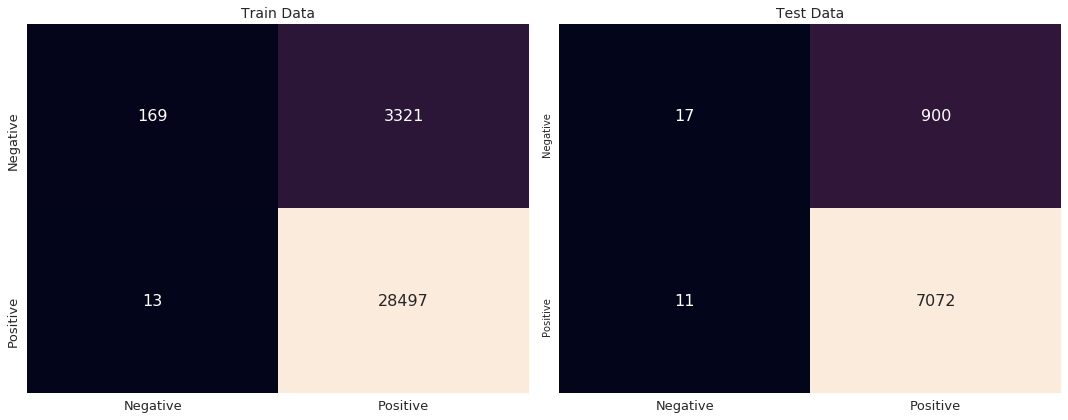

<IPython.core.display.Javascript object>

In [0]:
%%notify

plt.figure(figsize=(15,6))#.suptitle('Confusion Matrix for Train and Test data')
plt.subplot(1,2,1)

cm_bow_brute_train = confusion_matrix(y_train, clf.predict(X_train_transformed))
df_cm = pd.DataFrame(cm_bow_brute_train, range(2), range(2))
sbn.heatmap(df_cm, annot=True, annot_kws={"size":16}, cbar=False, fmt = 'd', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Train Data', fontsize = 14)

plt.subplot(1,2,2)
cm_bow_brute_test = confusion_matrix(y_test, clf.predict(X_test_transformed))
df_cm = pd.DataFrame(cm_bow_brute_test, range(2), range(2))
sbn.heatmap(df_cm, annot=True, annot_kws={"size":16}, cbar=False, fmt = 'd', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xticks(fontsize=13)
plt.xticks(fontsize=13)
plt.title('Test Data', fontsize = 14)

plt.tight_layout()

**Precision and Recall**

In [0]:
# print('Recall for BoW | Brute | train: {}'.format(recall_score(y_train, clf.predict(X_train_transformed))))
# print('Recall for BoW | Brute | test: {}'.format(recall_score(y_test, clf.predict(X_test_transformed))))
# print('Precision for BoW | Brute | train: {}'.format(precision_score(y_train, clf.predict(X_train_transformed))))
# print('Precision for BoW | Brute | test: {}'.format(precision_score(y_test, clf.predict(X_test_transformed))))

tn, fp, fn, tp = cm_bow_brute_train.ravel()
print('Recall for BoW | Brute | train: {}'.format(tp/(tp+fn)))
print('Precision for BoW | Brute | train: {}'.format(tp/(tp+fp)))
tn, fp, fn, tp = cm_bow_brute_test.ravel()
print('Recall for BoW | Brute | test: {}'.format(tp/(tp+fn)))
print('Precision for BoW | Brute | test: {}'.format(tp/(tp+fp)))

Recall for BoW | Brute | train: 0.9995440196422308
Precision for BoW | Brute | train: 0.8956251178578163
Recall for BoW | Brute | test: 0.9984469857405054
Precision for BoW | Brute | test: 0.8871048670346212


Let's create a dataframe using the function I defined above. It will help me create a heatmap at the end of this section.

In [0]:
DF_bow_brute_train = k_weight_score(clf.cv_results_)

In [0]:
# fname = open('/home/ucanreachtvk/data/knn_pickle_files/DF_bow_brute_train_50k.pkl','wb')
# pickle.dump(DF_bow_brute_train,fname)
# fname.close()

### GridSearch summary

Let's summarize the results of separate GridSearch performed for KNN on BoW for two algorithms: kd_tree and brute.

The following grid shows the accuracy of KNN for different values of **n_neighbors** and **weight** parameters.

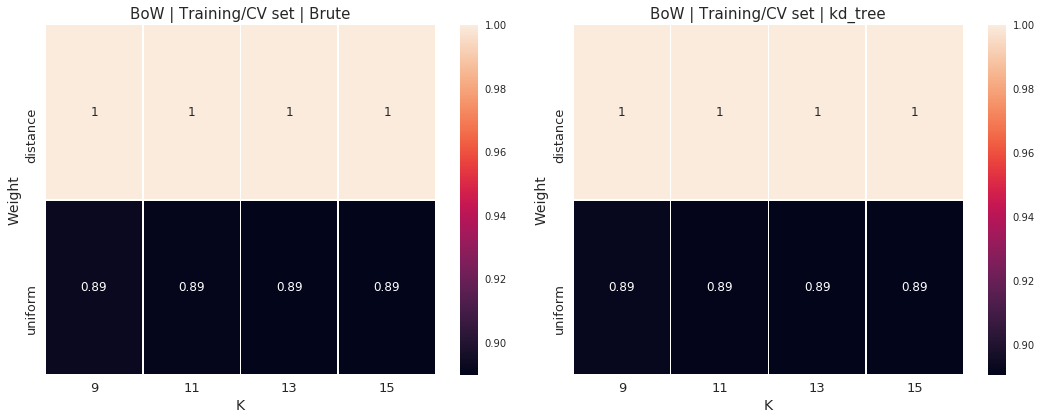

In [0]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sbn.heatmap(data=DF_bow_brute_train.pivot('weight','k','score'), annot=True, linewidth = 0.5)
plt.title('BoW | Training/CV set | Brute', fontsize = 15)
plt.xlabel('K', fontsize = 14)
plt.ylabel('Weight', fontsize = 14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.show()

plt.subplot(1,2,2)
sbn.heatmap(data=DF_bow_kd_train.pivot('weight','k','score'), annot=True, linewidth = 0.5)
plt.title('BoW | Training/CV set | kd_tree', fontsize = 15)
plt.xlabel('K', fontsize = 14)
plt.ylabel('Weight', fontsize = 14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.tight_layout()
plt.show()

Finally, to conclude this section, let's find the accuracy on test data using the best estimator found by GridSeach.

In [0]:
#X_test_transformed = bow_fit.transform(X_test)

In [0]:
clf.score(X_test_transformed, y_test)

0.886125

## Tfidf

In this section, we'll convert the raw text data into vectors by using the Tfidf format. The flow will be similar to what we did for BoW. 

Let's begin by creating a Tfidf object.

In [0]:
tfidf = TfidfVectorizer(ngram_range=(1,1))

In [0]:
tfidf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

Fit the train reviews corpus into Tfidf format. Following is a quick reminder of the raw data stored in X_train. 

In [0]:
X_train[0]

b'witti littl book make son laugh loud recit car drive along alway sing refrain he learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg'

In [0]:
tfidf_fit = tfidf.fit(X_train)

In [0]:
tfidf_fit

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)


Transform Train reviews

In [0]:
%%time
try:
    del(X_train_transformed)
except:
    print('variable not found.')
    
X_train_transformed = tfidf_fit.transform(X_train)

CPU times: user 972 ms, sys: 4.22 ms, total: 976 ms
Wall time: 974 ms


The X_train_transformed array now contains vectors in the Tfidf format.

In [0]:
X_train_transformed

<32000x22440 sparse matrix of type '<class 'numpy.float64'>'
	with 939149 stored elements in Compressed Sparse Row format>

Transform Test data as well.

In [0]:
X_test_transformed = tfidf_fit.transform(X_test)

In [0]:
X_test_transformed

<8000x22440 sparse matrix of type '<class 'numpy.float64'>'
	with 234338 stored elements in Compressed Sparse Row format>

Standardize the data

In [0]:
scaler = StandardScaler(with_mean=False)
X_train_transformed = scaler.fit_transform(X_train_transformed)

In [0]:
X_test_transformed = scaler.transform(X_test_transformed)

Similar to what we did for BoW, we need to reduce the dimensions of the Tfidf vectors so that the Kd_tree algorithm can handle the workload.

In [0]:
try:
    del(X_train_transformed_svd)
except:
    print('variable not found.')

In [0]:
svd = TruncatedSVD(n_components=100, random_state = 7)
X_train_transformed_svd = svd.fit_transform(X_train_transformed)
X_train_transformed_svd.shape

(32000, 100)

Transform test data too.

In [0]:
X_test_transformed_svd = svd.transform(X_test_transformed)
X_test_transformed_svd.shape

(8000, 100)

Now, it's time to start preparing for GridSearch! Let's split the Train data using TimeSeriesSplit() like we did with BoW. 

In [0]:
try:
    del(my_cv)
    del(tscv)
except:
    print('Some variables not found.')

tscv = TimeSeriesSplit(n_splits=3)
my_cv = tscv.split(X_train_transformed_svd)

Define the GridSearch object for KNN using the algorithm 'kd_tree'

In [0]:
knn = KNeighborsClassifier(algorithm = 'kd_tree')

param_grid = {
                'n_neighbors':[9,11,13,15],
                'weights' : ['uniform', 'distance']
             }

clf = GridSearchCV(estimator=knn, cv=my_cv, param_grid=param_grid, return_train_score=True, n_jobs=4)

Fit it!

In [0]:
%%notify
%%time
clf.fit(X_train_transformed_svd, y_train)

CPU times: user 2.24 s, sys: 380 ms, total: 2.62 s
Wall time: 17min 22s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f6c4bedcb48>,
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'n_neighbors': [9, 11, 13, 15], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

<IPython.core.display.Javascript object>

**Confusion Matrix**

Plot the confusion matrix for Train and test data using KD_tree algorithm of KNN on Tfidf represented data.

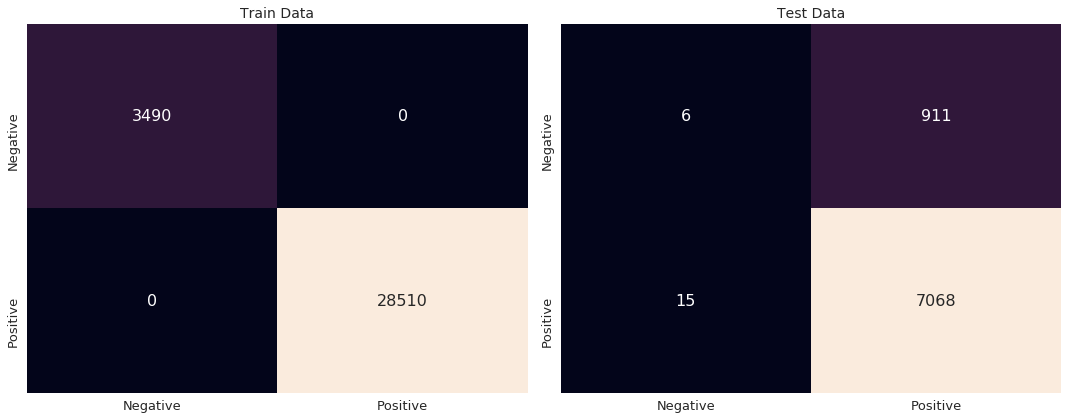

<IPython.core.display.Javascript object>

In [0]:
%%notify

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)

cm_tfidf_kd_train = confusion_matrix(y_train, clf.predict(X_train_transformed_svd))
df_cm = pd.DataFrame(cm_tfidf_kd_train, range(2), range(2))
sbn.heatmap(df_cm, annot=True, annot_kws={"size":16}, cbar=False, fmt = 'd', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Train Data', fontsize = 14)

plt.subplot(1,2,2)
cm_tfidf_kd_test = confusion_matrix(y_test, clf.predict(X_test_transformed_svd))
df_cm = pd.DataFrame(cm_tfidf_kd_test, range(2), range(2))
sbn.heatmap(df_cm, annot=True, annot_kws={"size":16}, cbar=False, fmt = 'd', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Test Data', fontsize = 14)

plt.tight_layout()

**Precision and Recall**

In [0]:
%%time

# print('Recall for Tfidf|Kd_tree|train: {}'.format(recall_score(y_train, clf.predict(X_train_transformed_svd))))
# print('Recall for Tfidf|Kd_tree|test: {}'.format(recall_score(y_test, clf.predict(X_test_transformed_svd))))
# print('Precision for Tfidf|Kd_tree|train: {}'.format(precision_score(y_train, clf.predict(X_train_transformed_svd))))
# print('Precision for Tfidf|Kd_tree|test: {}'.format(precision_score(y_test, clf.predict(X_test_transformed_svd))))

tn, fp, fn, tp = cm_tfidf_kd_train.ravel()
print('Recall for Tfidf | kd_tree | train: {}'.format(tp/(tp+fn)))
print('Precision for Tfidf | kd_tree | train: {}'.format(tp/(tp+fp)))
tn, fp, fn, tp = cm_tfidf_kd_test.ravel()
print('Recall for Tfidf | kd_tree | test: {}'.format(tp/(tp+fn)))
print('Precision for Tfidf | kd_tree | test: {}'.format(tp/(tp+fp)))


Recall for Tfidf | kd_tree | train: 1.0
Precision for Tfidf | kd_tree | train: 1.0
Recall for Tfidf | kd_tree | test: 0.9978822532825075
Precision for Tfidf | kd_tree | test: 0.8858252913898985
CPU times: user 216 µs, sys: 0 ns, total: 216 µs
Wall time: 180 µs


Save the results of cross validation in a dataframe.

In [0]:
DF_tfidf_kd_train = k_weight_score(clf.cv_results_)

In [0]:
fname = open('/home/ucanreachtvk/data/knn_pickle_files/DF_tfidf_kd_train_50k.pkl','wb')
pickle.dump(DF_tfidf_kd_train,fname)
fname.close()

**Brute algorithm of KNN**

Let's do the same analysis, but this time using the brute algrithm of KNN. It can handle large number of features. So, no need to reduce the dimensions using SVD.

Define cross validation split using TimeSeriesSplot()

In [0]:
try:
    del(my_cv)
    del(tscv)
except:
    print('Some variables not found.')

tscv = TimeSeriesSplit(n_splits=3)
my_cv = tscv.split(X_train_transformed)

Create a gridsearch object.

In [0]:
try:
    del(clf)
except:
    print('Variable not found')
    
knn = KNeighborsClassifier(algorithm='brute')

param_grid = {
                'n_neighbors':[9,11,13,15],
                'weights' : ['uniform', 'distance']
             }

clf = GridSearchCV(estimator=knn, cv=my_cv, param_grid=param_grid, return_train_score=True)

Fit it!

In [0]:
%%notify
%%time

clf.fit(X_train_transformed, y_train)

CPU times: user 6min 27s, sys: 2min 22s, total: 8min 49s
Wall time: 8min 42s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f6c476c1a98>,
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [9, 11, 13, 15], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

<IPython.core.display.Javascript object>

**Confusion matrix for Tfidf using Brute Algorithm**


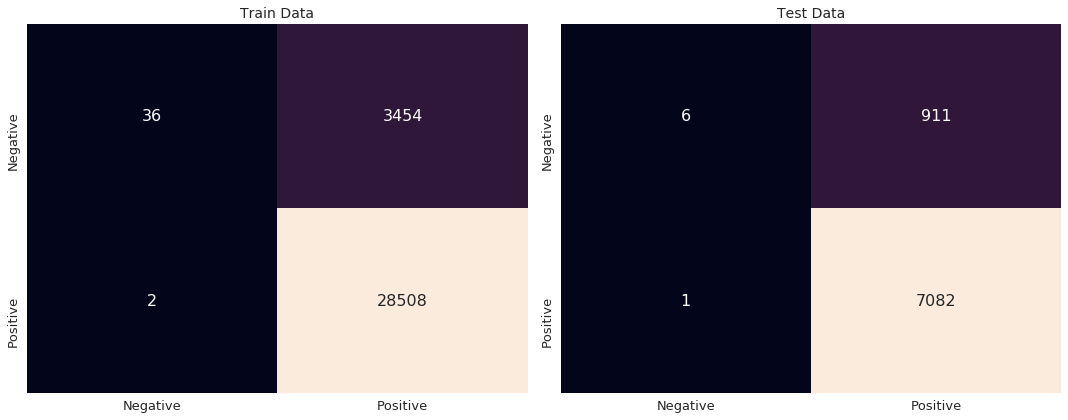

In [0]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)

cm_tfidf_brute_train = confusion_matrix(y_train, clf.predict(X_train_transformed))
df_cm = pd.DataFrame(cm_tfidf_brute_train, range(2), range(2))
sbn.heatmap(df_cm, annot=True, annot_kws={"size":16}, cbar=False, fmt = 'd', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Train Data', fontsize = 14)

plt.subplot(1,2,2)
cm_tfidf_brute_test = confusion_matrix(y_test, clf.predict(X_test_transformed))
df_cm = pd.DataFrame(cm_tfidf_brute_test, range(2), range(2))
sbn.heatmap(df_cm, annot=True, annot_kws={"size":16}, cbar=False, fmt = 'd', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Test Data', fontsize = 14)

plt.tight_layout()

**Precision and Recall**

In [0]:
# print('Recall for Tfidf | brute | train: {}'.format(recall_score(y_train, clf.predict(X_train_transformed))))
# print('Recall for Tfidf | brute | test: {}'.format(recall_score(y_test, clf.predict(X_test_transformed))))
# print('Precision for Tfidf | brute | train: {}'.format(precision_score(y_train, clf.predict(X_train_transformed))))
# print('Precision for Tfidf | brute | test: {}'.format(precision_score(y_test, clf.predict(X_test_transformed))))

tn, fp, fn, tp = cm_tfidf_brute_train.ravel()
print('Recall for Tfidf | Brute | train: {}'.format(tp/(tp+fn)))
print('Precision for Tfidf | Brute | train: {}'.format(tp/(tp+fp)))
tn, fp, fn, tp = cm_tfidf_brute_test.ravel()
print('Recall for Tfidf | Brute | test: {}'.format(tp/(tp+fn)))
print('Precision for Tfidf | Brute | test: {}'.format(tp/(tp+fp)))

Recall for Tfidf | Brute | train: 0.9999298491757278
Precision for Tfidf | Brute | train: 0.891934171829047
Recall for Tfidf | Brute | test: 0.9998588168855005
Precision for Tfidf | Brute | test: 0.886025272113099


Save the results of GridSearch in a dataframe.

In [0]:
DF_tfidf_brute_train = k_weight_score(clf.cv_results_)

In [0]:
fname = open('/home/ucanreachtvk/data/knn_pickle_files/DF_tfidf_brute_train.pkl','wb')
pickle.dump(DF_tfidf_brute_train,fname)
fname.close()

**Summary of Gridsearch of KNN using kd_tree and brute**

The cells give the accuracy for corresponding combination of K and weight.

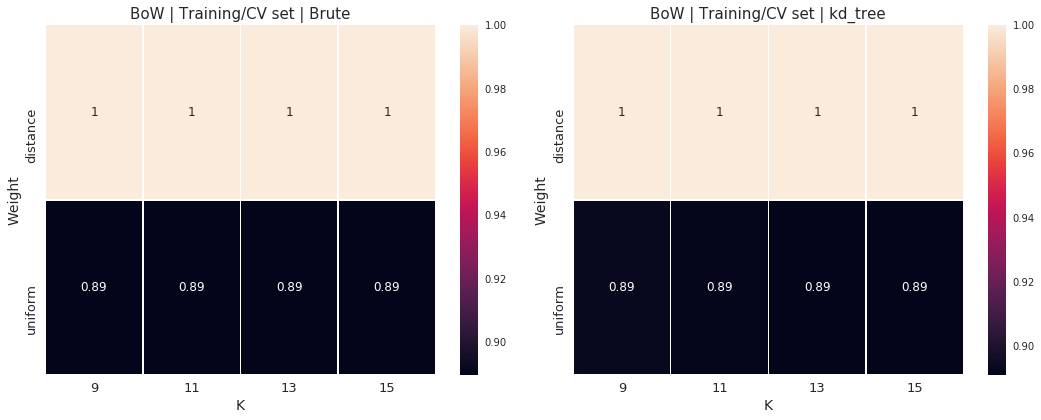

In [0]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sbn.heatmap(data=DF_tfidf_brute_train.pivot('weight','k','score'), annot=True, linewidth = 0.5)
plt.title('BoW | Training/CV set | Brute', fontsize = 15)
plt.xlabel('K', fontsize = 14)
plt.ylabel('Weight', fontsize = 14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.show()

plt.subplot(1,2,2)
sbn.heatmap(data=DF_tfidf_kd_train.pivot('weight','k','score'), annot=True, linewidth = 0.5)
plt.title('BoW | Training/CV set | kd_tree', fontsize = 15)
plt.xlabel('K', fontsize = 14)
plt.ylabel('Weight', fontsize = 14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.tight_layout()
plt.show()

To conclude this section on Tfidf, let's calculate the accuracy on test data using the best estimator found by gridsearch.

In [0]:
clf.score(X_test_transformed, y_test)

0.886

## Avg. W2V

In this section, we'll represent the reviews in W2V format and perform the same analysis as before.

For W2V howerver, each review will have only 50 dimenions which is very small compared to BoW and Tfidf. Hence, we can direcly use the kd_tree algorithm of KNN, without reducing the features first.

In [0]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [0]:
#!pip install --upgrade pip
#!pip install gensim
#!pip install google-compute-engine

Create a list of reviews to train our W2V model.

In [0]:
# Training a Word2Vec model using our own corpus

list_of_reviews = []

for review in X_train:
    list_of_reviews.append(review.decode('utf-8').split())

In [0]:
len(list_of_reviews)

32000

Train the W2V model and build vocabulary.

In [0]:
w2v_model = Word2Vec(list_of_reviews, min_count=4,size=50,workers=4)

How many words are there in the vocabulary?

In [0]:
words = list(w2v_model.wv.vocab)
print(len(words))

8739


Calculate **Avg.** W2V representation of the training corpus.

In [0]:
corpus_vec_train = np.zeros(shape=(50))

for review in X_train:
    review_vector = np.zeros(shape=(50))
    for word in review.decode('utf-8').split():
        try:
            
            review_vector += w2v_model.wv[word]
            
        except KeyError:
            continue
    
    review_vector /= 50
    corpus_vec_train=np.vstack((corpus_vec_train,review_vector))    
corpus_vec_train=np.delete(corpus_vec_train, 0, axis=0)

Let's confirm that each review has no more than 50 features.

In [0]:
corpus_vec_train.shape

(32000, 50)

Standardize train data

In [0]:
scaler = StandardScaler()
corpus_vec_train = scaler.fit_transform(corpus_vec_train)

Once again, split the data using timeSeriesSplit for cross validation.

In [0]:
try:
    del(tscv, my_cv)
except:
    print('variable/s not found.')
    
tscv = TimeSeriesSplit(n_splits=3)
my_cv = tscv.split(corpus_vec_train)

In [0]:
try:
    del(clf)
except:
    print('variable not found')

First let's try the kd_tree algorithm in GridSearch.

In [0]:
#del(clf)
knn = KNeighborsClassifier(algorithm='kd_tree')
param_grid = {
                'n_neighbors':[9,11,13,15],
                'weights' : ['uniform', 'distance']
             }
clf = GridSearchCV(estimator=knn, cv=my_cv, param_grid=param_grid, return_train_score=True, n_jobs=4)

In [0]:
%%notify
%%time


clf.fit(corpus_vec_train, y_train)

CPU times: user 1.19 s, sys: 201 ms, total: 1.39 s
Wall time: 7min 56s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f6c4a98bf68>,
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'n_neighbors': [9, 11, 13, 15], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

<IPython.core.display.Javascript object>

**Transform Test Data**

Here, I'm building the W2V vectors for test data using the W2V model which was built by looking at only the train data.

In [0]:
X_test.shape

(8000,)

In [0]:
corpus_vec_test = np.zeros(shape=(50))

for review in X_test:
    review_vector = np.zeros(shape=(50))
    for word in review.decode('utf-8').split():
        try:
            
            review_vector += w2v_model.wv[word]
            
        except KeyError:
            continue
    
    review_vector /= 50
    corpus_vec_test=np.vstack((corpus_vec_test,review_vector))    

corpus_vec_test=np.delete(corpus_vec_test, 0, axis=0)

Standardize test data.

In [0]:
corpus_vec_test = scaler.transform(corpus_vec_test)

In [0]:
corpus_vec_test.shape

(8000, 50)

**Confusion Matrix**

Plot confusion matrix for W2V, train and test data using KD tree approach

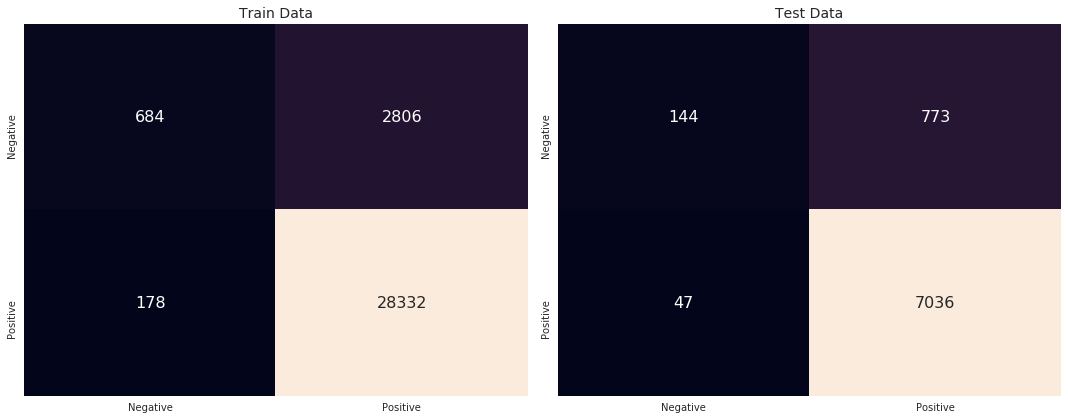

In [0]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)

cm_w2v_kd_train = confusion_matrix(y_train, clf.predict(corpus_vec_train))
df_cm = pd.DataFrame(cm_w2v_kd_train, range(2), range(2))
sbn.heatmap(df_cm, annot=True, annot_kws={"size":16}, cbar=False, fmt = 'd', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Train Data', fontsize = 14)

plt.subplot(1,2,2)
cm_w2v_kd_test = confusion_matrix(y_test, clf.predict(corpus_vec_test))
df_cm = pd.DataFrame(cm_w2v_kd_test, range(2), range(2))
sbn.heatmap(df_cm, annot=True, annot_kws={"size":16}, cbar=False, fmt = 'd', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Test Data', fontsize = 14)

plt.tight_layout()

**Precision and Recall**

In [0]:
# print('Precision for W2V | Kd_tree | train: {}'.format(precision_score(y_train, clf.predict(corpus_vec_train))))
# print('Precision for W2V | Kd_tree | test: {}'.format(precision_score(y_test, clf.predict(corpus_vec_test))))
# print('Recall for W2V | Kd_tree | train: {}'.format(recall_score(y_train, clf.predict(corpus_vec_train))))
# print('Recall for W2V | Kd_tree | test: {}'.format(recall_score(y_test, clf.predict(corpus_vec_test))))

tn, fp, fn, tp = cm_w2v_kd_train.ravel()
print('Recall for W2V | kd_tree | train: {}'.format(tp/(tp+fn)))
print('Precision for W2V | kd_tree | train: {}'.format(tp/(tp+fp)))
tn, fp, fn, tp = cm_w2v_kd_test.ravel()
print('Recall for W2V | kd_tree | test: {}'.format(tp/(tp+fn)))
print('Precision for W2V | kd_tree | test: {}'.format(tp/(tp+fp)))

Recall for W2V | kd_tree | train: 0.9937565766397756
Precision for W2V | kd_tree | train: 0.9098850279401375
Recall for W2V | kd_tree | test: 0.9933643936185232
Precision for W2V | kd_tree | test: 0.9010116532206428


Save results of gridsearch in a dataframe.

In [0]:
DF_w2v_kd_train = k_weight_score(clf.cv_results_)

In [0]:
import pickle
fname = open('/home/ucanreachtvk/data/knn_pickle_files/DF_w2v_kd_train_50k.pkl','wb')
pickle.dump(DF_w2v_kd_train,fname)
fname.close()

**Brute KNN on W2V**

In [0]:
try:
    del(clf)
    del(tscv, my_cv)
except:
    print('Some variables not found.')
    
tscv = TimeSeriesSplit(n_splits=3)
my_cv = tscv.split(corpus_vec_train)

Define the GridSearch object for KNN using brute.

In [0]:
knn = KNeighborsClassifier(algorithm='brute')
param_grid = {
                'n_neighbors':[9,11,13,15],
                'weights' : ['uniform', 'distance']
             }
clf = GridSearchCV(estimator=knn, cv=my_cv, param_grid=param_grid, n_jobs=2, return_train_score=True)

In [0]:
%%notify
clf.fit(corpus_vec_train, y_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f6c46d3d8e0>,
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'n_neighbors': [9, 11, 13, 15], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

<IPython.core.display.Javascript object>

**Confusion Marix for Avg. W2V using brute algorithm**

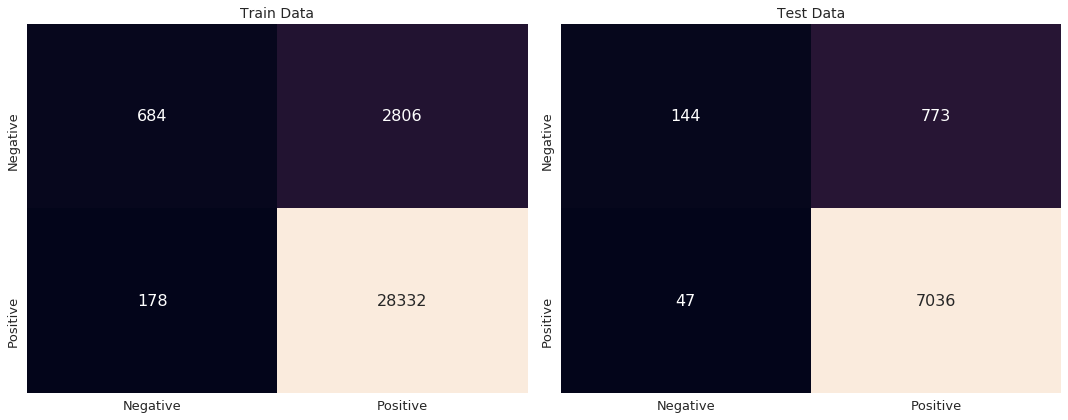

In [0]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)

cm_w2v_brute_train = confusion_matrix(y_train, clf.predict(corpus_vec_train))
df_cm = pd.DataFrame(cm_w2v_brute_train, range(2), range(2))
sbn.heatmap(df_cm, annot=True, annot_kws={"size":16}, cbar=False, fmt = 'd', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Train Data', fontsize = 14)

plt.subplot(1,2,2)
cm_w2v_brute_test = confusion_matrix(y_test, clf.predict(corpus_vec_test))
df_cm = pd.DataFrame(cm_w2v_brute_test, range(2), range(2))
sbn.heatmap(df_cm, annot=True, annot_kws={"size":16}, cbar=False, fmt = 'd', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Test Data', fontsize = 14)

plt.tight_layout()

**Precision and Recall**

In [0]:
# print('Precision for W2V | brute | train: {}'.format(precision_score(y_train, clf.predict(corpus_vec_train))))
# print('Precision for W2V | brute | test: {}'.format(precision_score(y_test, clf.predict(corpus_vec_test))))
# print('Recall for W2V | brute | train: {}'.format(recall_score(y_train, clf.predict(corpus_vec_train))))
# print('Recall for W2V | brute | test: {}'.format(recall_score(y_test, clf.predict(corpus_vec_test))))

tn, fp, fn, tp = cm_w2v_brute_train.ravel()
print('Recall for w2v | Brute | train: {}'.format(tp/(tp+fn)))
print('Precision for w2v | Brute | train: {}'.format(tp/(tp+fp)))
tn, fp, fn, tp = cm_w2v_brute_test.ravel()
print('Recall for w2v | Brute | test: {}'.format(tp/(tp+fn)))
print('Precision for w2v | Brute | test: {}'.format(tp/(tp+fp)))

Recall for w2v | Brute | train: 0.9937565766397756
Precision for w2v | Brute | train: 0.9098850279401375
Recall for w2v | Brute | test: 0.9933643936185232
Precision for w2v | Brute | test: 0.9010116532206428


Save results of grid search in a dataframe.

In [0]:
DF_w2v_brute_train = k_weight_score(clf.cv_results_)

Plot the summary of GridSearch!

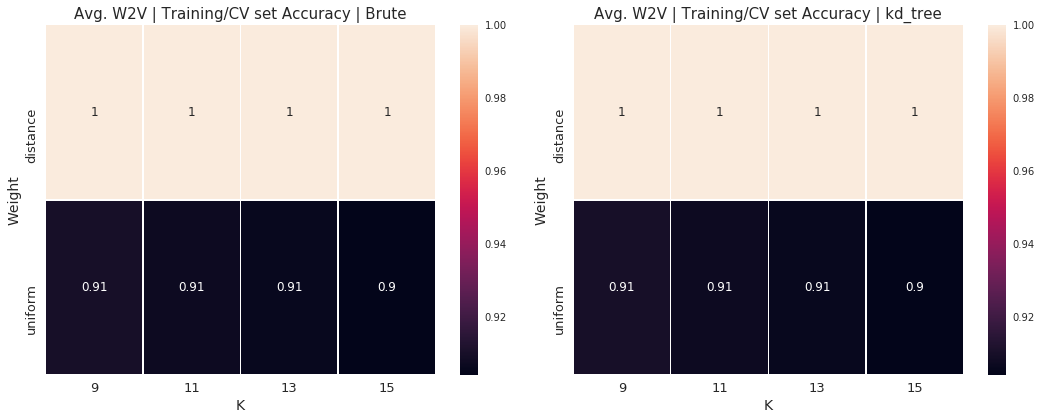

In [0]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sbn.heatmap(data=DF_w2v_brute_train.pivot('weight','k','score'), annot=True, linewidth = 0.5)
plt.title('Avg. W2V | Training/CV set Accuracy | Brute', fontsize = 15)
plt.xlabel('K', fontsize = 14)
plt.ylabel('Weight', fontsize = 14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.subplot(1,2,2)
sbn.heatmap(data=DF_w2v_kd_train.pivot('weight','k','score'), annot=True, linewidth = 0.5)
plt.title('Avg. W2V | Training/CV set Accuracy | kd_tree', fontsize = 15)
plt.xlabel('K', fontsize = 14)
plt.ylabel('Weight', fontsize = 14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.tight_layout()
plt.show()

To conclude this section on KNN on Avg W2V, let's calculate the accuracy on test data obtained using the best estimator found by gridsearch.

In [0]:
clf.score(corpus_vec_test, y_test)

0.8975

## Tfidf weighted W2V

In this final section of this notebook, we'll work with the Tfidf weighted W2V form of food reviews. Once again, each review vector is going to have just 50 features, so KNN can use kd_tree without worrying about the dimensionality. Let's begin!

Get the feature names from tfidf fit model.

In [0]:
features = tfidf_fit.get_feature_names()

Build vector of training data corpus in Tfidf weighted W2V format

In [0]:
corpus_train_tfidf_weighted_w2v = np.zeros(shape=(50))

review_number = 0

for review in X_train:
    review_vector_tfidf_weighted = np.zeros(shape=(50))
    tfidf_sum = 0
    for word in review.decode('utf-8').split():
        try:
            tfidf_value = X_train_transformed[review_number, features.index(word)]
            review_vector_tfidf_weighted += w2v_model.wv[word] * tfidf_value
            tfidf_sum += tfidf_value
            
        except KeyError:
            continue
    
    review_number += 1
    
    if tfidf_sum !=0:
        review_vector_tfidf_weighted /= tfidf_sum
    corpus_train_tfidf_weighted_w2v=np.vstack((corpus_train_tfidf_weighted_w2v,review_vector_tfidf_weighted))
    
corpus_train_tfidf_weighted_w2v = np.delete(corpus_train_tfidf_weighted_w2v, 0, axis=0)

In [0]:
corpus_train_tfidf_weighted_w2v.shape

(32000, 50)

Standardize data.

In [0]:
scaler = StandardScaler()
corpus_train_tfidf_weighted_w2v = scaler.fit_transform(corpus_train_tfidf_weighted_w2v)

Transform Test data. Note that, there are some words in the test data corpus, which the W2V and Tfidf models have not seen. Such cases have to be handled with care. The avg. W2V is essentially a sum of all vectors belonging to a review, and the words which were not found have been skipped.

In [0]:
corpus_test_tfidf_weighted_w2v = np.zeros(shape=(50))

review_number = 0

for review in X_test:
    
    review_vector_tfidf_weighted = np.zeros(shape=(50))
    tfidf_sum = 0
    for word in review.decode('utf-8').split():
        
            flag_tfidf = True
            flag_w2v = True
            
            try:
                
                tfidf_value = X_train_transformed[review_number, features.index(word)]
                    
            except ValueError as v:
                
                flag_tfidf = False
                tfidf_value = 1
                    
            try:
                w2v_value = w2v_model.wv[word]
                review_vector_tfidf_weighted += w2v_value * tfidf_value    
                if flag_tfidf == True:
                    tfidf_sum += tfidf_value
                    
            except KeyError:
                
                flag_w2v = False
                continue                 
            # review_vector_tfidf_weighted += w2v_model.wv[word] * tfidf_value
            # tfidf_sum += tfidf_value
                                   
    review_number += 1
    if tfidf_sum != 0:
        review_vector_tfidf_weighted /= tfidf_sum
    corpus_test_tfidf_weighted_w2v=np.vstack((corpus_test_tfidf_weighted_w2v,review_vector_tfidf_weighted))
    
corpus_test_tfidf_weighted_w2v = np.delete(corpus_test_tfidf_weighted_w2v, 0, axis=0)

In [0]:
corpus_test_tfidf_weighted_w2v.shape

(8000, 50)

standardize test data.

In [0]:
corpus_test_tfidf_weighted_w2v = scaler.transform(corpus_test_tfidf_weighted_w2v)

Our train and test vectors are ready and it's again time to perform grid search!

Let's split the data for cross validation.

In [0]:
try:
    del(tscv)
    del(my_cv)
except:
    pass

tscv = TimeSeriesSplit(n_splits=3)
my_cv = tscv.split(corpus_train_tfidf_weighted_w2v)

Define the Grid Search, first for kd_tree method.

In [0]:
try:
    
    del(clf)
except:
    print('variable not found.')

knn = KNeighborsClassifier(algorithm = 'kd_tree')
param_grid = {
                'n_neighbors':[9,11,13,15],
                'weights' : ['uniform', 'distance'],
             }
clf = GridSearchCV(estimator=knn, cv=my_cv, param_grid=param_grid, n_jobs=4, return_train_score=True)

In [0]:
%%notify
clf.fit(corpus_train_tfidf_weighted_w2v, y_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f6c20cf2888>,
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'n_neighbors': [9, 11, 13, 15], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

<IPython.core.display.Javascript object>

**Confusion Matrix KD tree**

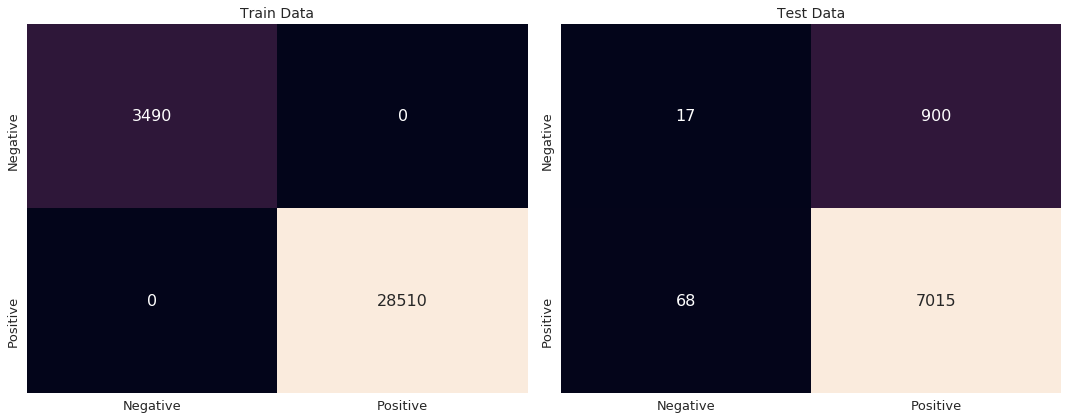

In [0]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)

cm_tfidf_weighted_w2v_kd_train = confusion_matrix(y_train, clf.predict(corpus_train_tfidf_weighted_w2v))
df_cm = pd.DataFrame(cm_tfidf_weighted_w2v_kd_train, range(2), range(2))
sbn.heatmap(df_cm, annot=True, annot_kws={"size":16}, cbar=False, fmt = 'd', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Train Data', fontsize = 14)

plt.subplot(1,2,2)
cm_tfidf_weighted_w2v_kd_test = confusion_matrix(y_test, clf.predict(corpus_test_tfidf_weighted_w2v))
df_cm = pd.DataFrame(cm_tfidf_weighted_w2v_kd_test, range(2), range(2))
sbn.heatmap(df_cm, annot=True, annot_kws={"size":16}, cbar=False, fmt = 'd', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Test Data', fontsize = 14)

plt.tight_layout()

**Precision and Recall**

In [0]:
tn, fp, fn, tp = cm_tfidf_weighted_w2v_kd_train.ravel()
print('Recall for tfidf_weighted_w2v | kd_tree | train: {}'.format(tp/(tp+fn)))
print('Precision for tfidf_weighted_w2v | kd_tree | train: {}'.format(tp/(tp+fp)))
tn, fp, fn, tp = cm_tfidf_weighted_w2v_kd_test.ravel()
print('Recall for tfidf_weighted_w2v | kd_tree | test: {}'.format(tp/(tp+fn)))
print('Precision for tfidf_weighted_w2v | kd_tree | test: {}'.format(tp/(tp+fp)))

Recall for tfidf_weighted_w2v | kd_tree | train: 1.0
Precision for tfidf_weighted_w2v | kd_tree | train: 1.0
Recall for tfidf_weighted_w2v | kd_tree | test: 0.9903995482140336
Precision for tfidf_weighted_w2v | kd_tree | test: 0.8862918509159823


In [0]:
DF_tfidf_weighted_w2v_kd_train = k_weight_score(clf.cv_results_)

**Brute KNN on Tfidf weighted W2V**

In [0]:
try:
    
    del(clf, tscv, my_cv)
except:
    print('variables not found.')
    
tscv = TimeSeriesSplit(n_splits=3)
my_cv = tscv.split(corpus_train_tfidf_weighted_w2v)

knn = KNeighborsClassifier(algorithm = 'brute')

param_grid = {
                'n_neighbors':[9,11,13,15],
                'weights' : ['uniform', 'distance']
             }
clf = GridSearchCV(estimator=knn, cv=my_cv, param_grid=param_grid, n_jobs=2, return_train_score=True)

In [0]:
clf.fit(corpus_train_tfidf_weighted_w2v, y_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f6c4ebe27d8>,
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'n_neighbors': [9, 11, 13, 15], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

**Confusion Matrix**

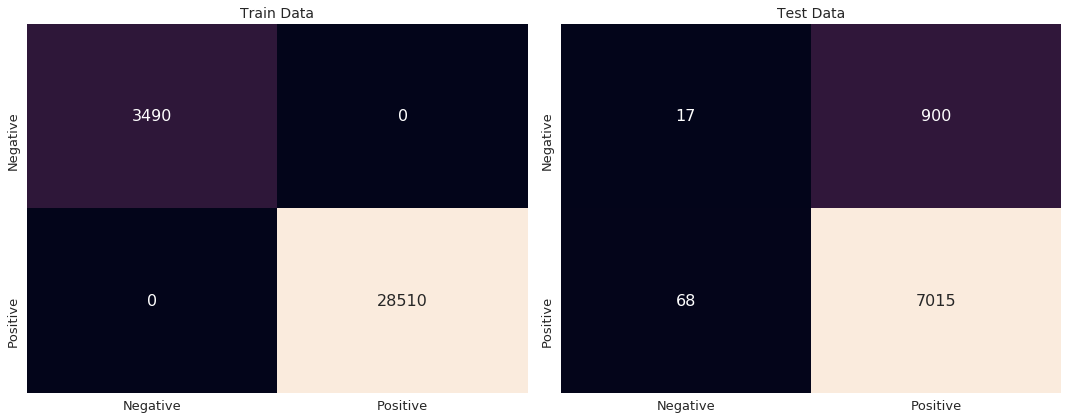

In [0]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)

cm_tfidf_weighted_w2v_brute_train = confusion_matrix(y_train, clf.predict(corpus_train_tfidf_weighted_w2v))
df_cm = pd.DataFrame(cm_tfidf_weighted_w2v_brute_train, range(2), range(2))
sbn.heatmap(df_cm, annot=True, annot_kws={"size":16}, cbar=False, fmt = 'd', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Train Data', fontsize = 14)

plt.subplot(1,2,2)
cm_tfidf_weighted_w2v_brute_test = confusion_matrix(y_test, clf.predict(corpus_test_tfidf_weighted_w2v))
df_cm = pd.DataFrame(cm_tfidf_weighted_w2v_brute_test, range(2), range(2))
sbn.heatmap(df_cm, annot=True, annot_kws={"size":16}, cbar=False, fmt = 'd', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Test Data', fontsize = 14)

plt.tight_layout()

**Precision and Recall**

In [0]:
# print('Precision for Tfidf Weighted W2V|Brute|train: {}'.format(precision_score(y_train, clf.predict(corpus_train_tfidf_weighted_w2v))))
# print('Precision for Tfidf Weighted W2V|Brute|test: {}'.format(precision_score(y_test, clf.predict(corpus_test_tfidf_weighted_w2v))))
# print('Recall for Tfidf Weighted W2V|Brute|train: {}'.format(recall_score(y_train, clf.predict(corpus_train_tfidf_weighted_w2v))))
# print('Recall for Tfidf Weighted W2V|Brute|test: {}'.format(recall_score(y_test, clf.predict(corpus_test_tfidf_weighted_w2v))))

tn, fp, fn, tp = cm_tfidf_weighted_w2v_brute_train.ravel()
print('Recall for tfidf_weighted_w2v | Brute | train: {}'.format(tp/(tp+fn)))
print('Precision for tfidf_weighted_w2v | Brute | train: {}'.format(tp/(tp+fp)))
tn, fp, fn, tp = cm_tfidf_weighted_w2v_brute_test.ravel()
print('Recall for tfidf_weighted_w2v | Brute | test: {}'.format(tp/(tp+fn)))
print('Precision for tfidf_weighted_w2v | Brute | test: {}'.format(tp/(tp+fp)))


Recall for tfidf_weighted_w2v | Brute | train: 1.0
Precision for tfidf_weighted_w2v | Brute | train: 1.0
Recall for tfidf_weighted_w2v | Brute | test: 0.9903995482140336
Precision for tfidf_weighted_w2v | Brute | test: 0.8862918509159823


In [0]:
DF_tfidf_weighted_w2v_brute_train = k_weight_score(clf.cv_results_)

**Summary of Grid Search of KNN on Tfidf weighted W2V**

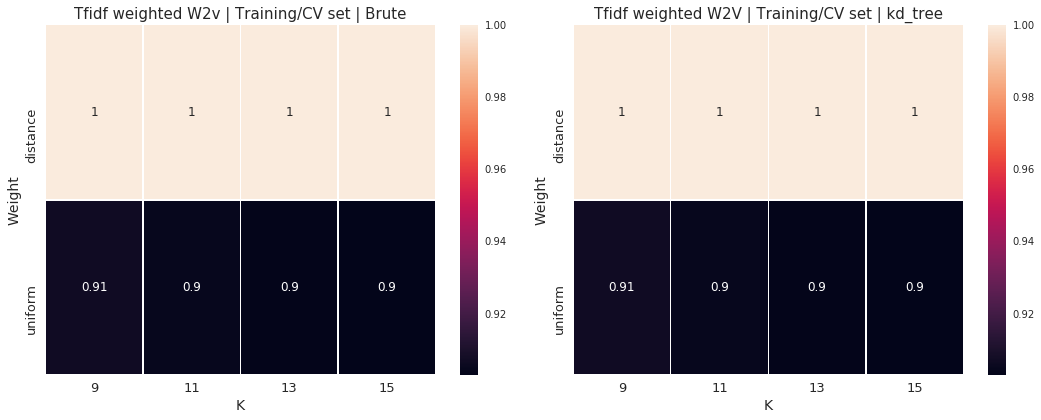

In [0]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sbn.heatmap(data=DF_tfidf_weighted_w2v_brute_train.pivot('weight','k','score'), annot=True, linewidth = 0.5)
plt.title('Tfidf weighted W2v | Training/CV set | Brute', fontsize = 15)
plt.xlabel('K', fontsize = 14)
plt.ylabel('Weight', fontsize = 14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.subplot(1,2,2)
sbn.heatmap(data=DF_tfidf_weighted_w2v_kd_train.pivot('weight','k','score'), annot=True, linewidth = 0.5)
plt.title('Tfidf weighted W2V | Training/CV set | kd_tree', fontsize = 15)
plt.xlabel('K', fontsize = 14)
plt.ylabel('Weight', fontsize = 14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.tight_layout()
plt.show()

To end this section, let's calculate the accuracy on test data using the best estimator found by gridsearch.

In [0]:
clf.score(corpus_test_tfidf_weighted_w2v, y_test)

0.879

### Conclusion:

* KNN was used to classify the Amazon Food Reviews into two classes - positive/negative.
* Using GridSearch, we tried several combinations of K and the weight hyperparameters.
* TimeSeriesSplit was used to partition data for cross validation.
* Since the dataset is not balanced, accuracy is not the best metric to use. Precision is what we should be interested in, because, we need to reduce **False Positives** i.e. the reviews which are actually negative but have been classified as positve.